# Bayesian networks

A *bayesian network* is a directed acyclic graph such that each node represents a random variable and has an associated probability distribution: 

* for a node without any predecessors (i.e., without any incoming edges), it is an unconditional probability distribution
* for a node with predecessors (i.e., with some incoming edges), it is a conditional probability distribution, conditioning on the variables represented by the other end of the incoming edges. We will call these variables *parents*.

The picture below shows a bayesian networks with 5 variables: two unconditional (*Bulglary*, *Earthquake*), and three conditional:

* *Alarm*, conditioning on *Bulglary* and *Earthquake* (i.e., *Bulgary* and *Earthquake* are parents for *Alarm*),
* *JohnCalls*, conditioning on *Alarm*
* *MaryCalls*, also conditioning on *Alarm*

In this particular example, each variables is a boolean variable, that is it can be either *true* or *false*. The probability distributions are incomplete, only specifying the probability for a variable being *true*. Fortunately, it is sufficient to subtract the given values from, to arrive at probabilities for *false* and thus complete the distributions.

For the conditional probability distributions, each row represents a separate distribution conditioning on the values of the parent variables given in the left-hand side of the distribution. For example:
$$ P(Alarm = true | Bulglary = true, Earhquake = false) = 0.94 $$
and by following the previous paragraph:
$$ P(Alarm = false | Bulglary = true, Earhquake = false) = 1 - P(Alarm = true | Bulglary = true, Earhquake = false) = 1 - 0.94 = 0.06 $$

![](aima-images/aima4_fig13_2.png)

Let us now try to come up with a data structure suitable for representing a bayesian network. We will use strings as variable names and allow more-or-less any values to be the elements of the domain of the variable. To make the code somewhat more readable, we will use Python's `typing` module and introduce some type aliases:

In [1]:
from typing import *

Variable = str
DomainElement = Hashable # anything that can be a key of a dictionary

Now, what is a probability distribution? A mapping from the elements of a domain to probabilities. In Python's terms: a dictionary `dict` from `DomainElement` to `float`

In [2]:
ProbabilityDistribution = Dict[DomainElement, float]

Conditional probability distributions is somewhat more complicated, as it requires a separate probability distribution `ProbabilityDistribution` for each assignment of values to conditions. We will represent each assignment `Assignment` as a tuple of `DomainElements` of arbitrary lenth, and the conditional probability distribution `ConditionalProbabilityDistribution` as a dictionary `dict` from `Assignment`s to `ProbabilityDistribution`s. In order to ensure that we know which position in `Assignment` represents which variable, we will introduce an auxiliary type `Parents`, being a tuple of `Variable`s of arbitrary length. It serves the same purpose as the header in the top-left corner in the conditional probability distributions given in the picture above.

In [3]:
Assignment = Tuple[DomainElement, ...]
ConditionalProbabilityDistribution = Dict[Assignment, ProbabilityDistribution]
Parents = Tuple[Variable, ...]

The following class `BayesianNet` uses these type aliases to define a class representing a bayesian network along with some auxiliary functions. The detailed description is given below it, along with some examples how to use it.

In [4]:
class BayesianNet:        
    _unconditional: Dict[Variable, ProbabilityDistribution]
    _conditional: Dict[Variable, Tuple[Parents, ConditionalProbabilityDistribution]]
    _domain: Dict[Variable, Iterable[DomainElement]]
    
    def __init__(self):
        self._unconditional = {}
        self._conditional = {}
        self._domain = {}        
        
    def _check_and_normalize(self, distribution: ProbabilityDistribution) -> ProbabilityDistribution:
        assert len(distribution.keys()) >= 2
        if None in distribution.values():
            rem = sum([f for f in distribution.values() if f is not None])
            assert 0 <= rem < 1
            noneKey = [k for k, v in distribution.items() if v is None]
            assert len(noneKey) == 1
            distribution[noneKey[0]] = 1 - rem
        assert all(0<v<1 for v in distribution.values())
        assert sum(distribution.values()) == 1
        return distribution
        
    def addUnconditionalVariable(self, name: Variable, distribution: ProbabilityDistribution) -> None:        
        assert name not in self._conditional
        assert name not in self._unconditional
        distribution = self._check_and_normalize(distribution)
        self._unconditional[name] = distribution
        self._domain[name] = set(distribution.keys())
    
    def addConditionalVariable(self, name: Variable, parents: Parents, cpt: ConditionalProbabilityDistribution) -> None:        
        assert name not in self._conditional
        assert name not in self._unconditional
        assert isinstance(parents, tuple)
        assert len(parents) > 0
        assert all(len(parents) == len(k) for k in cpt.keys())
        domain = set(next(iter(cpt.values())).keys())
        assert all(v.keys() == domain for v in cpt.values())        
        cpt = {k: self._check_and_normalize(distribution) for k, distribution in cpt.items()}
        self._conditional[name] = (parents, cpt)
        self._domain[name] = domain
    
    def addBooleanUnconditionalVariable(self, name: Variable, pTrue: float) -> None:
        assert 0 < pTrue < 1
        self.addUnconditionalVariable(name, {True: pTrue, False: 1-pTrue})
        
    def addBooleanConditionalVariable(self, name: Variable, parents: Parents, cpt: Dict[Assignment, float]):
        cpt = {k: {True: v, False: 1-v} for k, v in cpt.items()}
        self.addConditionalVariable(name, parents, cpt)
        
    def domain(self, name: Variable) -> Iterable[DomainElement]:
        return self._domain[name]
    
    def variables(self) -> Iterable[Variable]:
        return self._conditional.keys() | self._unconditional.keys()
    
    def parents(self, name: Variable) -> Parents:
        if name in self._conditional:
            return self._conditional[name][0]
        else:
            return []
    
    def p(self, name: Variable, value: DomainElement, condition: Dict[Variable, DomainElement]):
        if name in self._conditional:
            parents, cpt = self._conditional[name]
            assert all(p in condition for p in parents)
            condition = tuple(condition[p] for p in parents)
            dist = cpt[condition]
        else:
            assert name in self._unconditional
            dist = self._unconditional[name]
        return dist[value]

We will create a network corresponding to the one given in the picture above. For easier reading the same picture is repeated below.

![](aima-images/aima4_fig13_2.png)

We begin by creating a new network in the variable `bn` and adding an unconditional variable *B* using `addUncoditionalVariable`. Its first argument is the variable, the second is a probability distribution. As this variable is a boolean variable, it is a dictionary from the boolean values to probabilities. It is allowed for one of the probabilities to remain unspecified (using `None`), in which case it is automatically computed from the remaining values.

In [5]:
bn = BayesianNet()
bn.addUnconditionalVariable('B', {True: 0.001, False: None})

Observe that we require the random variable to have at least two elements of the domain, and the numeric values given must be probabilities and not arbitrary numbers. The following cell contains commented-out code, you can uncomment each line separately, execute the cell and observe that an exception was raised.

In [6]:
#bn.addUnconditionalVariable('B1', {True: 1})
#bn.addUnconditionalVariable('B1', {True: -1, False: 2})
#bn.addUnconditionalVariable('B1', {True: None, False: None})

For boolean variables it is somewhat cumbersome to write all this boilerplate by hand, so there's an auxiliary method `addBooleanUnconditionalVariable`, which expects only a variable name and the probability for *true*. The following line adds an unconditional variable `E` with $P(E=true) = 0.002$ and $P(E=false) = 0.998$ (computed automatically)

In [7]:
bn.addBooleanUnconditionalVariable('E', 0.002) # the same as bn.addUnconditionalVariable('E', {True: 0.002, False: None})

Now let us add the conditional variable *A*, following the distribution given in the picture. The method `addConditionalVariable` expects three parameters: a variable name, a tuple of variable names representing parents of the variable and a conditional probability distribution, i.e., a dictionary from tuples of domain elements to probability distributions. The keys in the dictionary `cpd` are each a pair of boolean values, and their meaning is given by the variable `parents`: the first value is the value for the variable *B* and the other for varialbe *E*. The probability distributions follow the same conventions as described earlier for `addUnconditionalVariable`.

In [8]:
parents = ('B', 'E')
cpd = {(True, True): {True: .95, False: None}, 
       (True, False): {True: .94, False: None}, 
       (False, True): {True: .29, False: None}, 
       (False, False): {True: .001, False: None}}

bn.addConditionalVariable('A', parents, cpd)

Again, writing the boilerplate for boolean variables is cumbersome. Enters `addBooleanConditionalVariable`, which expects only probabilities for true in the dictionary, instead of complete probability distributions. The following two lines add two variables, *J* and *M*, both having a single parent: *A*. Observe that the second argument is still a tuple (consisting of a single element) and similarly the keys in the conditional probability distribution are tuples of a single element.

In [9]:
bn.addBooleanConditionalVariable('J', ('A',), {(True,): .9, (False,): .05})
bn.addBooleanConditionalVariable('M', ('A',), {(True,): .7, (False,): .01})

Let us see what variables are available in the networks:

In [10]:
bn.variables()

{'A', 'B', 'E', 'J', 'M'}

What is the domain of the variable *A*?

In [11]:
bn.domain('A')

{False, True}

What are the parents of the variable *A*?

In [12]:
bn.parents('A')

('B', 'E')

What is the probability $P(A=true | B=true, E=false)$?

In [13]:
bn.p('A', True, {'B': True, 'E': False})

0.94

Observe that the method `p` expects three arguments: the variable, the value we are interested in, and the conditions. There may be more information than necessary in the third argument, but there cannot be less. For example, the following cell works just fine, returning the probability of the alarm ringing given that there was a bulgary, there was no earthquake and both Mary and John called, the last two pieces of information being superfluous.

In [14]:
bn.p('A', True, {'B': True, 'E': False, 'M': True, 'J': True})

0.94

`p` will not, however, be able to deal with not enough information. The following cell will fail, as it is unknown whether there was a bulgary or not.

In [15]:
#bn.p('A', True, {'E': False})

`p` works fine for unconditional variables and simply ignores the last argument (both cells below should return the same value):

In [16]:
bn.p('B', True, {'E': False})

0.001

In [17]:
bn.p('B', True, None)

0.001

## Task 1: Topological sorting

A *topological order* is any order such that for any variable, all its parents are earlier in the order. It is a stepping stone for an inference algorithm further down the line. The following function is checks whether the given ordering is, in fact, a topological order. If it is not, it raises an exception.

In [18]:
def verify_topological_order(bn: BayesianNet, ordering: List[Variable]):
    for i, var in enumerate(ordering):
        assert all(p in ordering[:i] for p in bn.parents(var))

For example, *B, E, A, J, M* is a topological ordering for the network we constructed earlier, while *A, B, E, J, M* is not (so the second cell should fail)

In [19]:
verify_topological_order(bn, ['B', 'E', 'A', 'J', 'M'])

In [20]:
#verify_topological_order(bn, ['A', 'B', 'E', 'J', 'M'])

Complete the following function `topological_sort` such that it returns a list of variables of the given `BayesianNet` in a *topological order*. Topological sorting is quite similar to forward chaining with Horn clauses, but without the risk of cycles, so you should have no problem coming up with a solution. (Additional reading: page 434 in AIMA 4ed, in Chapter 13.2)

In [21]:


def topological_sort(bn: BayesianNet) -> List[Variable]:
    ...
    def dfs(node, memory):
        if node not in memory:
            memory.append(node)
        for parent in bn.parents(node):
            if parent not in memory:
                dfs(parent, memory)
        return 1

    parents = []

    for node in bn.variables():
        for parent in bn.parents(node):
            if parent not in parents:
                parents.append(parent)

    sortedVariables = [node for node in (set(bn.variables()) - set(parents)) ]       
    for node in sortedVariables:
        dfs(node, sortedVariables)
    
    return sortedVariables[::-1]

Lets see if your code works correctly! The following cell should not fail.

In [22]:
verify_topological_order(bn, topological_sort(bn))

In [23]:
topological_sort(bn)

['E', 'B', 'A', 'J', 'M']

## Task 2: Implement inference algorithm for Bayesian Networks

Complete the following function `enumeration_ask` by implementing the algorithm *ENUMERATION-ASK* given in Figure 13.11 of AIMA 4ed. It should return a probability distribution for the variable `X` given the assignment (results of observation) `e` and the Bayesian network `bn`.

In [24]:
from copy import deepcopy
def enumeration_ask(X: Variable, e: Assignment, bn: BayesianNet) -> ProbabilityDistribution:

    def enumerate_all(vars, e, bn: BayesianNet, sum = 0):
        if len(vars) == 0:
            return 1.0
        Y = vars.pop(0)
        eCopy = deepcopy(e)

        condition = {}
        for parent in bn.parents(Y):
            if parent in eCopy.keys():
                condition[parent] = eCopy[parent]

        if Y in eCopy.keys():
            return bn.p(Y, eCopy[Y], condition) * enumerate_all(vars, eCopy, bn, sum)
        else:
            for value in bn.domain(Y):
                varsCopy = deepcopy(vars)
                eCopy[Y] = value
                sum += bn.p(Y, eCopy[Y], condition) * enumerate_all(varsCopy, eCopy, bn, sum)
            return sum

    Q = {}
    for xi in bn.domain(X):
        e[X] = xi
        Q[xi] = enumerate_all(topological_sort(bn), e, bn)

    # print(Q)
    factor = 1/sum(Q.values())
    normalizedQ = {k: v*factor for k, v in Q.items()}
    print(normalizedQ)
    
    return normalizedQ


Assume that both John and Mary called. AIMA gives the probability for an ongoing bulgary of around 0.284 and 0.716 for the lack of bulgary (see page 446 of AIMA 4ed). Lets see if you agree (the following cell should not fail)

In [25]:
prob = enumeration_ask("B", {"J": True, "M": True}, bn)
assert abs(prob[True] - 0.284) <= 0.001
assert abs(prob[False] - 0.716) <= 0.001

{False: 0.716134217314384, True: 0.28386578268561596}


## Task 3: Biased coins

Complete the following function `coins` such that it returns a Bayesian networks representing the following problem: We have a bag of three biased coins *A*, *B*, and *C* with probabilities of coming up heads of `pa`, `pb`, and `pc`, respectively. One coin is drawn randomly from the bag (with equal likelihood of drawing each of the three coins), and then the coin is flipped three times to generate the outcomes *X1*, *X2*, and *X3*. Call the conditional variables `X1`, `X2`, `X3` and define them over a binary domain consisting of the values `'H'` and `'T'`. Call the unconditional variable `Coins` and define over the domain of `'A'`, `'B'`, `'C'`


In [26]:
def coins(pa: float, pb: float, pc: float) -> BayesianNet:
    coins = BayesianNet()
    coins.addUnconditionalVariable('Coins', {'A': 1/3, 'B' : 1/3, 'C' : 1/3})
    coins.addConditionalVariable('X1', ('Coins', ), {('A',) : {'H' : pa, 'T' : 1-pa}, ('B', ) : {'H' : pb, 'T' : 1-pb}, ('C', ) : {'H' : pc, 'T' : 1-pc}})
    coins.addConditionalVariable('X2', ('Coins', ), {('A',) : {'H' : pa, 'T' : 1-pa}, ('B', ) : {'H' : pb, 'T' : 1-pb}, ('C', ) : {'H' : pc, 'T' : 1-pc}})
    coins.addConditionalVariable('X3', ('Coins', ), {('A',) : {'H' : pa, 'T' : 1-pa}, ('B', ) : {'H' : pb, 'T' : 1-pb}, ('C', ) : {'H' : pc, 'T' : 1-pc}})
    return coins

The following cell computes the probability distribution for the variable `Coins` with probabilities of coming up heads, respectively, 30%, 60% and 75% assuming that the coin drawn from the bag yielded heads, heads and tails.

In [27]:
coins_bn = coins(.3, .6, .75)
pd = enumeration_ask('Coins', {'X1': 'H', 'X2': 'H', 'X3': 'T'}, coins_bn)
pd

{'C': 0.40453074433656966, 'B': 0.41423948220064727, 'A': 0.18122977346278318}


{'C': 0.40453074433656966, 'B': 0.41423948220064727, 'A': 0.18122977346278318}

Let's see if your solution is correct:

In [28]:
assert abs(pd['A'] - 0.181) <= 0.005
assert abs(pd['B'] - 0.414) <= 0.005
assert abs(pd['C'] - 0.405) <= 0.005
assert pd['B'] > pd['C'] > pd['A']

Extension to many throws and coins

In [29]:
assert(1 == -1) #ASSERT STOP, TO NOT MAKE YOU DOWNLOAD/IMPORT LIBRARIES IF YOU ARE NOT INTERESTED IN SEEING WHAT'S FURTHER

AssertionError: 

In [30]:
from matplotlib import pyplot as plt
from string import ascii_uppercase
import itertools
import random

Helper Functions
To make new instances of a multi coin/multi throw problem

In [31]:
def generateThrows(number: int) -> dict:
    random.seed()
    output = {}
    for i in range(number):
        name = 'Throw' + str(i + 1)
        rand = random.randint(0, 1)
        if rand == 0:
            output[name] = 'T'
        else:
            output[name] = 'H'
    return output

def generateCoins(number: int) -> list[float]:
    random.seed()
    output = []
    for _ in range(number):
        output.append(random.uniform(0, 1))
    return output


In [33]:
def iterAllStrings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_uppercase, repeat=size):
            yield "".join(s)

def multipleCoins(probabilities: list[float], throws: dict) -> BayesianNet:
    net = BayesianNet()
    iterator = 0
    coins = {}
    cpd = {}
    for s in itertools.islice(iterAllStrings(), len(probabilities)):
        name = s
        cpd[name] = 1/len(probabilities)
        coins[name] = probabilities[iterator]
        iterator += 1
    cpd['A'] += 1 - sum(cpd.values())   #to help the cpd normalization, but i didn't want to modify your code, and it's such a small precision error
    #that it shouldn't influence the output by a lot in any case.
    net.addUnconditionalVariable('Coins', cpd)

    for i in range(len(throws)):
        name = 'Throw' + str(i+1)
        parentDependencies = {}
        for coin, prob in coins.items():
            parentDependencies[(coin, )] = {'H' : prob, 'T' : 1 - prob}
        net.addConditionalVariable(name, ('Coins', ), parentDependencies)
    return net


{'C': 0.061655861910887504, 'D': 0.21922084234982223, 'B': 0.16162714264767694, 'A': 0.21655511690684848, 'E': 0.09949816778517045, 'F': 0.2414428683995944}


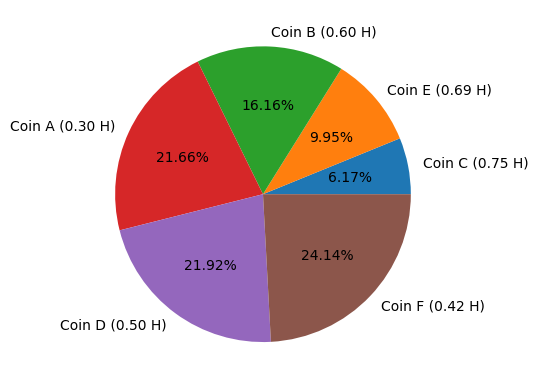

In [34]:
coins = [0.3, 0.6, 0.75, 0.5, 0.69, 0.420]
throws = {'Throw1': 'T', 'Throw2': 'T', 'Throw3': 'H', 'Throw4' : 'H', 'Throw5' : 'T'}
coins_bn = multipleCoins(coins, throws)
pd = enumeration_ask('Coins', throws, coins_bn)

# RANDOMLY GENERATED THINGS ARE FUN BUT REGARDLESS OF THAT I THINK THAT MANUAL INPUT IS MORE INSIGHTFUL AND INTERESTING ANYWAYS
# coins = generateCoins(random.randint(2, 10))
# throws = generateThrows(random.randint(2, 10))
# coins_bn = multipleCoins(coins, throws)
# pd = enumeration_ask('Coins', throws, coins_bn)


plt.pie(sorted(pd.values()), labels = [f'Coin {str(i)} ({p:.2f} H)' for i, p in sorted(zip(sorted(pd.keys()), coins), key = lambda item: pd[item[0]])], autopct = '%1.2f%%')
plt.show()

---
The pictures are from "Artificial Intelligence: A Modern Approach" 4rd ed. Task 3 is adapted from chapter 14 of "Artificial Intelligence: A Modern Approach" 3rd ed.

The typing in this notepad is a bit sloppy. There should be a separate type `IncompleteProbabilityDistribution = Dict[DomainElement, Optional[float]]` explicitly allowing for `None` instead of a probability value. It would, however, make the code harder to follow.